# Exploratory Data Analysis Notebook

The domain of this demo is urban planning. Therefore, we aim at modeling the amount of taxi rides requested.

We start with downloading the data and plotting them yearly.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from shapely import wkt

from google.cloud import bigquery
from sklearn.preprocessing import StandardScaler

dataset_id = "chicago_taxi_trips"
project = "bigquery-public-data"
table_id = "taxi_trips"

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the dataset
dataset_ref = client.dataset(dataset_id=dataset_id,
                             project=project)

# Construct a reference to the table
table_ref = dataset_ref.table(table_id=table_id)

# Fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "full" table
df = client.list_rows(table, max_results=5).to_dataframe()
df

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,e6133727cf30a5e90e9b12781fecc836b639e7e6,ff650cbcf1ba62caac94578e2e96316c742818a3bcf4ac...,2019-06-01 21:30:00+00:00,2019-06-01 21:45:00+00:00,756,4.29,<NA>,<NA>,<NA>,<NA>,...,0.0,13.50,Cash,Flash Cab,NaN,NaN,None,NaN,NaN,None
1,e61e3ef44de4b1f0cbb6c2b9d8ca77fd671348da,8dd990653cc2793d96b80ae45e928afc9a590b21b491ee...,2019-06-11 14:30:00+00:00,2019-06-11 14:45:00+00:00,480,1.00,<NA>,<NA>,<NA>,<NA>,...,0.0,6.75,Cash,KOAM Taxi Association,NaN,NaN,None,NaN,NaN,None
2,e61795294b6d61832a05d1885f951c7589420da5,d38a242610110db56d50433ee978b21d989c43fd63cc98...,2019-06-21 09:00:00+00:00,2019-06-21 09:15:00+00:00,320,0.70,<NA>,<NA>,<NA>,<NA>,...,0.0,5.25,Cash,Chicago Taxicab,NaN,NaN,None,NaN,NaN,None
3,e61e8b346096869ad08680311f127bfd26914f61,57dbcc9d59c0730235c8d003188f5e4a109acd35a61266...,2019-06-08 04:15:00+00:00,2019-06-08 04:15:00+00:00,300,0.00,<NA>,<NA>,<NA>,<NA>,...,0.0,5.75,Cash,Blue Ribbon Taxi Association Inc.,NaN,NaN,None,NaN,NaN,None
4,e624c9803c880d2bbf671c0e5b44b7891c1f4b92,99cde37aeabdaa069a6b277bae9976d94d0095aba59302...,2019-06-07 16:00:00+00:00,2019-06-07 16:00:00+00:00,407,0.87,<NA>,<NA>,<NA>,<NA>,...,0.0,8.50,Credit Card,Flash Cab,NaN,NaN,None,NaN,NaN,None


<Axes: xlabel='year'>

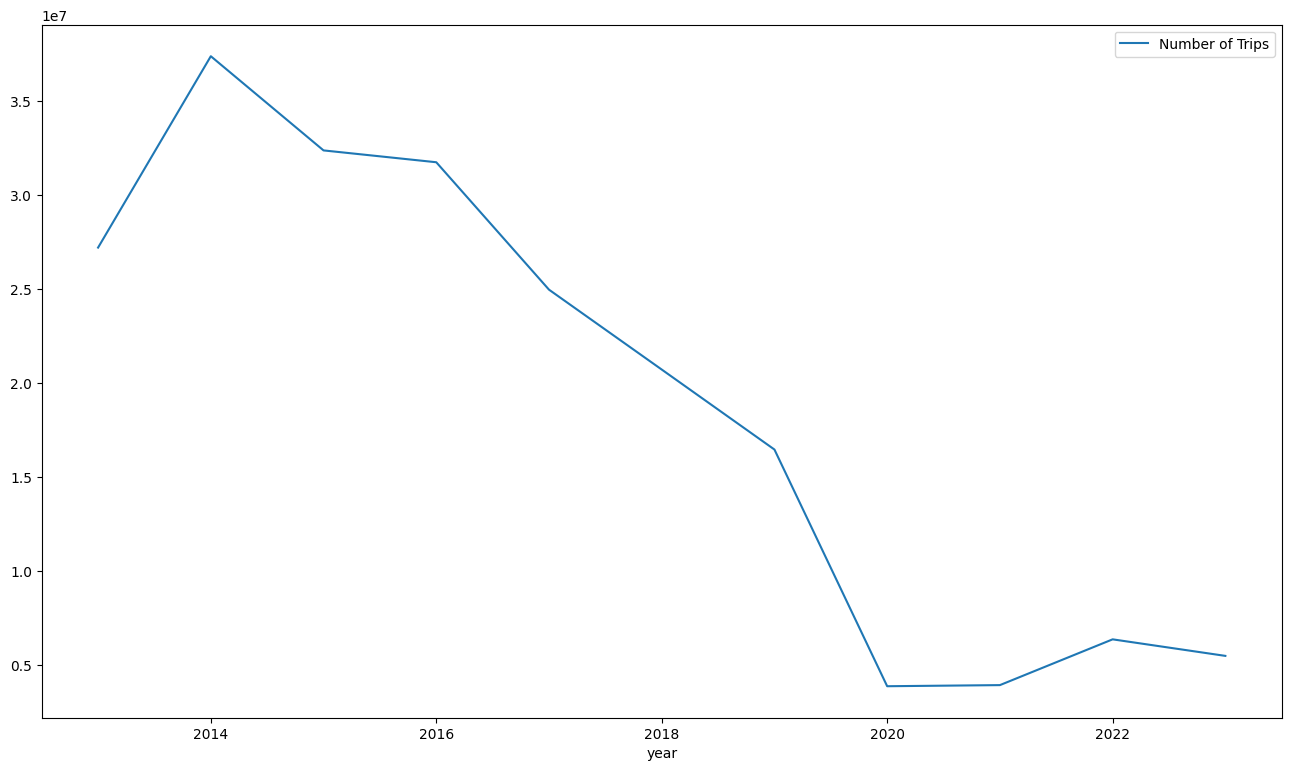

In [22]:
# Get the number of rides per year
query_rides_per_year = """
SELECT EXTRACT(YEAR FROM trip_start_timestamp) AS year, 
       COUNT(1) AS num_trips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
GROUP BY year 
ORDER BY year;
"""
query_job_rides_per_year = client.query(query_rides_per_year)

# API request - run the query, and return a pandas DataFrame
df_rides_per_year = query_job_rides_per_year.to_dataframe()
df_rides_per_year = df_rides_per_year.rename(columns={'num_trips': 'Number of Trips'}).set_index('year')

# Plot the results
fig, ax = plt.subplots(1, figsize=(16, 9))
sns.lineplot(df_rides_per_year, ax=ax)

The time series clearly shows a trend and the anomaly due to COVID-19 pandemic.

Now let us go in more detail, by adding the month information to the time series.

<Axes: ylabel='Number of Trips'>

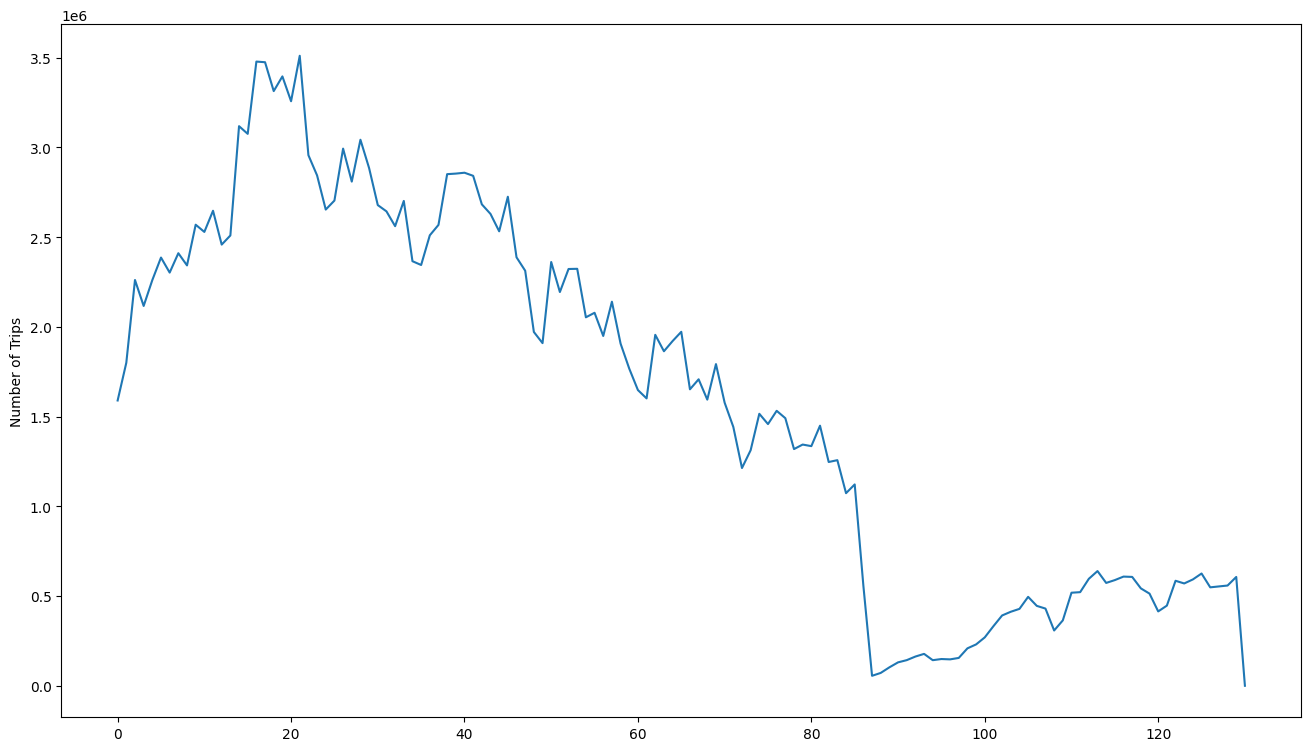

In [23]:
query_rides_per_year_month = """
SELECT
  EXTRACT(YEAR FROM trip_start_timestamp) AS year,
  EXTRACT(MONTH FROM trip_start_timestamp) AS month,
  COUNT(1) AS num_trips
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
GROUP BY
  year, month
ORDER BY
  year, month;
"""

# Set up the query
query_job_rides_per_year_month = client.query(query_rides_per_year_month) 

# API request - run the query, and return a pandas DataFrame
df_rides_per_year_month = query_job_rides_per_year_month.to_dataframe() 
df_rides_per_year_month['timestamp'] = pd.to_datetime(df_rides_per_year_month[['year', 'month']].assign(DAY=1))
df_rides_per_year_month = df_rides_per_year_month.rename(columns={'num_trips': 'Number of Trips'})

# Plot the results
fig, ax = plt.subplots(1, figsize=(16, 9))
sns.lineplot(df_rides_per_year_month['Number of Trips'], ax=ax)

There is a clear effect of seasonality, and the effect of the COVID-19 pandemic effect is magnified. It literally breaks the time series in two, with different trends.

Let us change the view and plot the data with a heatmap displaying every year in a different row, and every month in a different cell.

<Axes: xlabel='Month', ylabel='Year'>

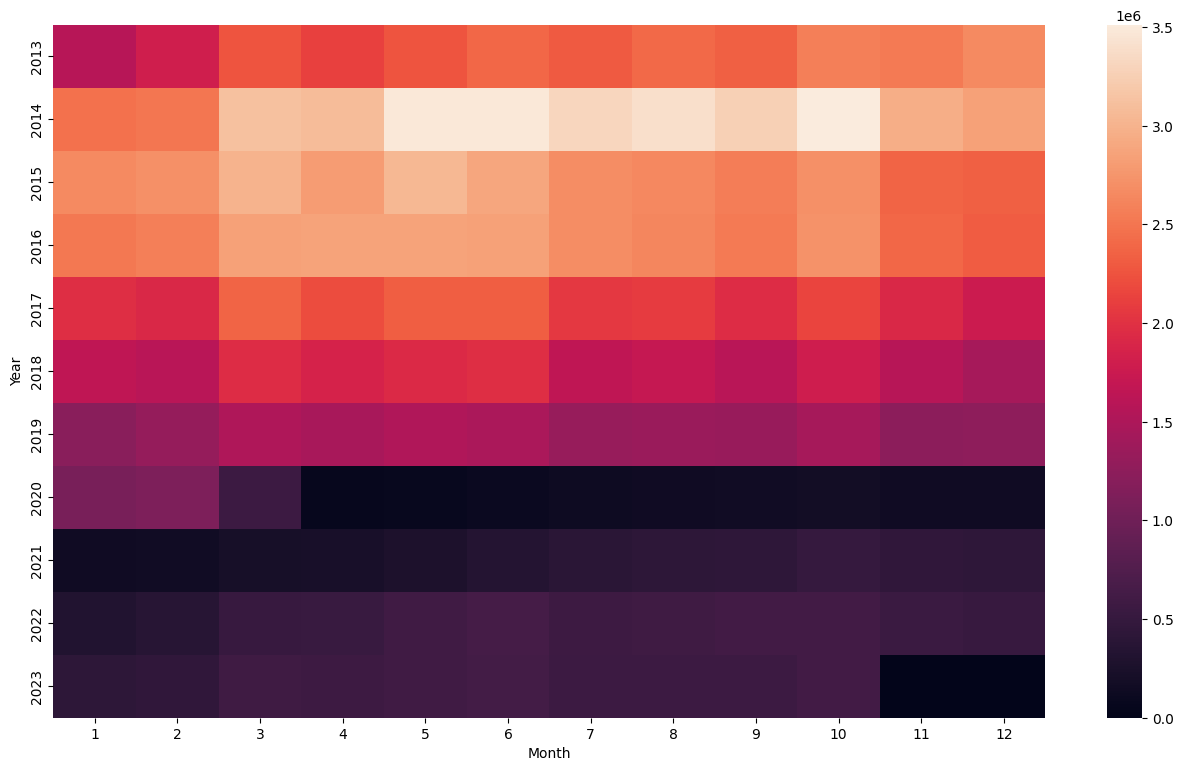

In [24]:
df_rides_per_year_month_heatmap = df_rides_per_year_month.pivot(index='year', columns='month', values='Number of Trips')
df_rides_per_year_month_heatmap = df_rides_per_year_month_heatmap.fillna(0.).astype(int)
df_rides_per_year_month_heatmap.index.name = 'Year'
df_rides_per_year_month_heatmap.columns.name = 'Month'

fig, ax = plt.subplots(1, figsize=(16, 9))
sns.heatmap(data=df_rides_per_year_month_heatmap, ax=ax)

To highlight the effect of seasonality, let us switch to a line plot.

(1.0, 13.9)

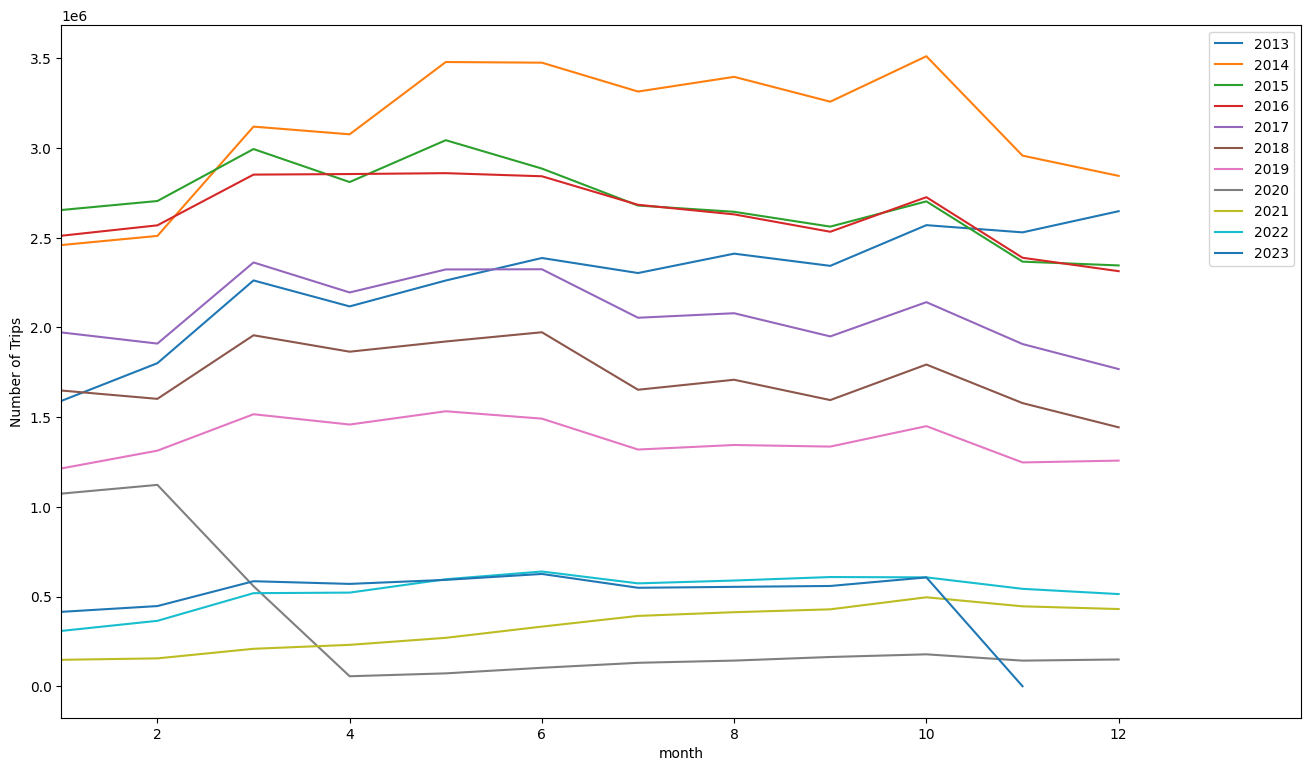

In [25]:
fig, ax = plt.subplots(1, figsize=(16, 9))
for year in sorted(set(df_rides_per_year_month['year'])):
    mask = (df_rides_per_year_month['year'] == year)
    data = df_rides_per_year_month.loc[mask].set_index('month')['Number of Trips']
    sns.lineplot(data, label=year, ax=ax)
ax.set_xlim([1, 13.9])

Since the time series span a very different range of values, let us standardize them to further highlight the effect of seasonality.

(1.0, 13.9)

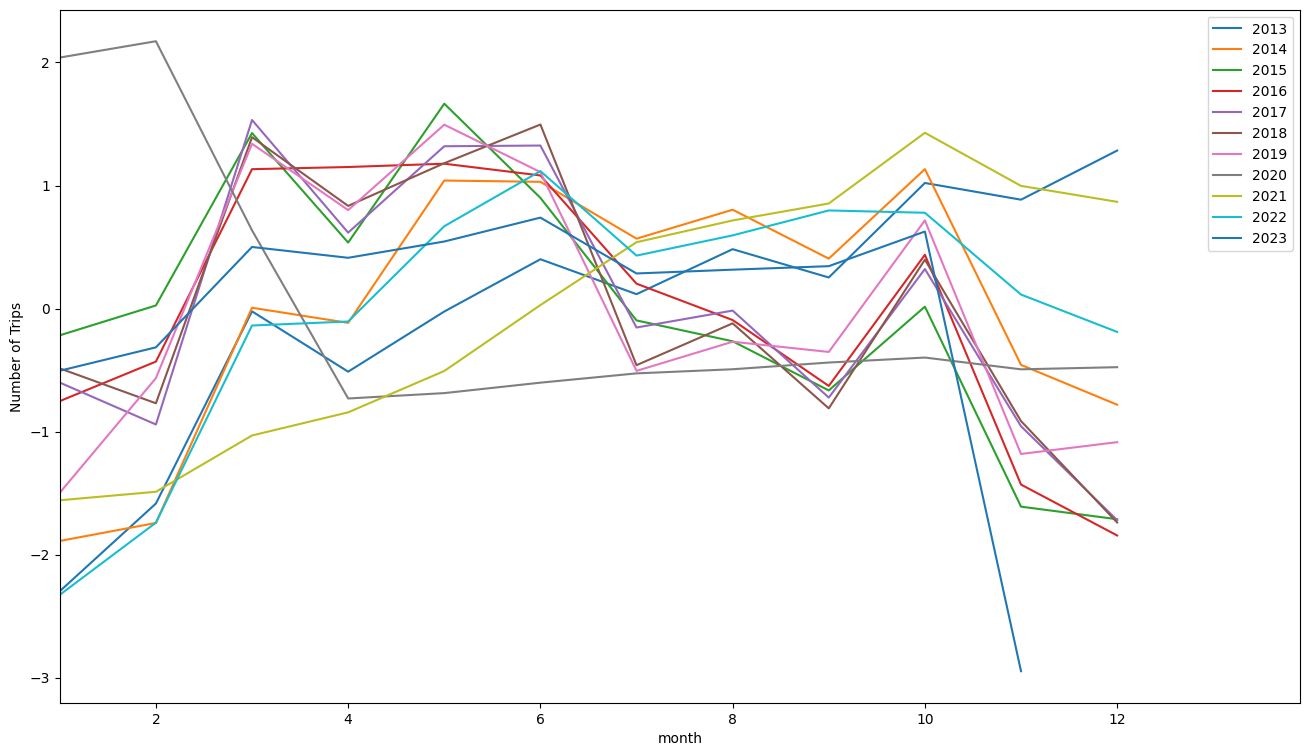

In [26]:
scaler = StandardScaler()

fig, ax = plt.subplots(1, figsize=(16, 9))
for year in sorted(set(df_rides_per_year_month['year'])):
    mask = (df_rides_per_year_month['year'] == year)
    data = df_rides_per_year_month.loc[mask].set_index('month')['Number of Trips']
    data = pd.Series(scaler.fit_transform(data.values.reshape(-1, 1)).flatten(),
                     index=data.index,
                     name='Number of Trips')
    sns.lineplot(data, label=year, ax=ax)
ax.set_xlim([1, 13.9])

Despite the COVID-19 disruption, the effect of the monthly seasonality is manifest.

Now let us deepen our analysis on a more fine-grained level. We do this by averaging the values as a function of weekday and hour, and we compute the lineplots.

/var/tmp/ipykernel_39736/1408345804.py:29: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_rides_per_ymdh.groupby(['Week Day', 'Hour']).agg({'Number of Trips': sum}).reset_index().pivot(index='Hour', columns='Week Day', values='Number of Trips')


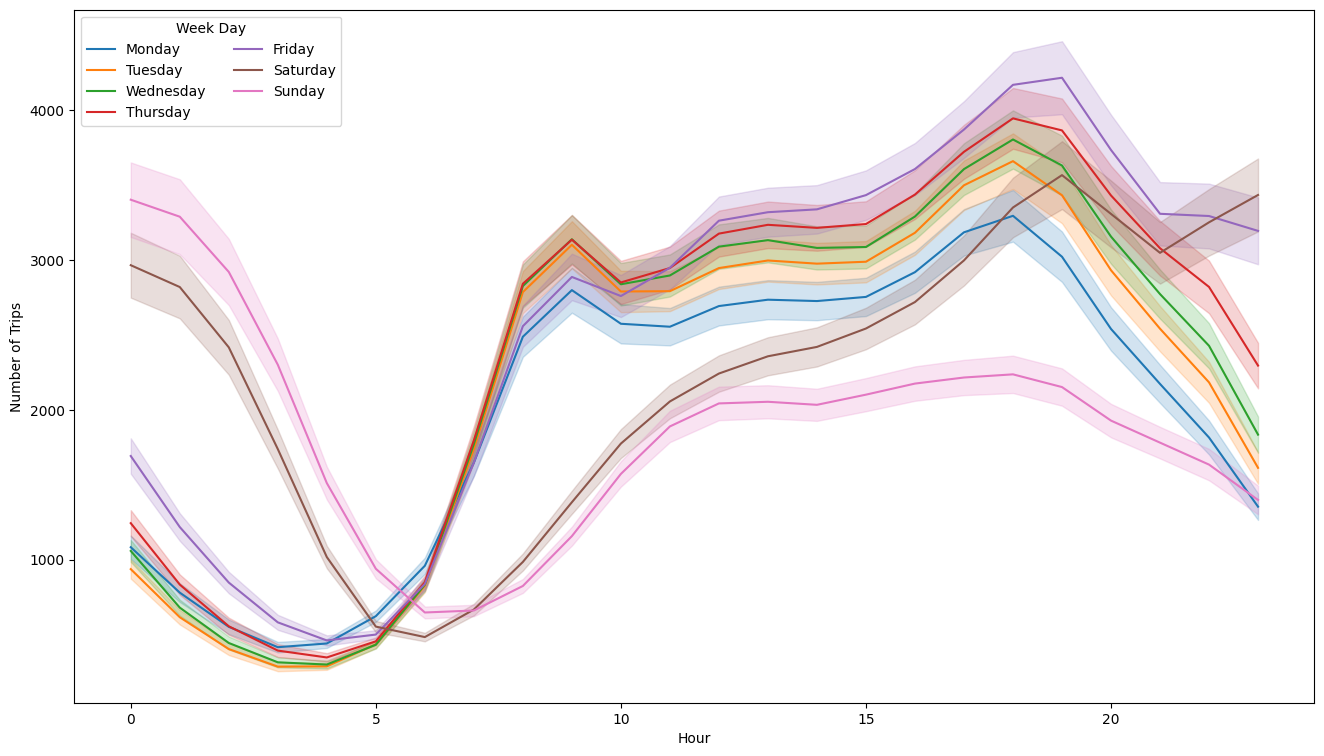

In [7]:
query_rides_per_ymdh = """
SELECT
  EXTRACT(YEAR FROM trip_start_timestamp) AS Year,
  EXTRACT(MONTH FROM trip_start_timestamp) AS Month,
  EXTRACT(DAY FROM trip_start_timestamp) AS Day,
  EXTRACT(HOUR FROM trip_start_timestamp) AS Hour,
  COUNT(1) AS num_trips,
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
GROUP BY
  year, month, day, hour
ORDER BY
  year, month, day, hour;
"""

# Set up the query
query_job_rides_per_ymdh = client.query(query_rides_per_ymdh) 

# API request - run the query, and return a pandas DataFrame
df_rides_per_ymdh = query_job_rides_per_ymdh.to_dataframe() 
df_rides_per_ymdh['timestamp'] = pd.to_datetime(df_rides_per_ymdh[['Year', 'Month', 'Day', 'Hour']])
df_rides_per_ymdh = df_rides_per_ymdh.rename(columns={'num_trips': 'Number of Trips'})
df_rides_per_ymdh['Week Day'] = pd.to_datetime(df_rides_per_ymdh['timestamp']).dt.day_name()

# Plot the results
# fig, ax = plt.subplots(1, figsize=(8, 4.5))
# sns.lineplot(df_rides_per_ymdh['Number of Trips'], ax=ax)

df_rides_per_ymdh.groupby(['Week Day', 'Hour']).agg({'Number of Trips': sum}).reset_index().pivot(index='Hour', columns='Week Day', values='Number of Trips')

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(1, figsize=(16, 9))
sns.lineplot(data=df_rides_per_ymdh,
             x='Hour', y='Number of Trips',
             hue='Week Day', hue_order=weekdays,
             errorbar=('se', 2),  # 2 standard deviations
             ax=ax)
ax.legend(title='Week Day', ncol=2)

There is a clear effect of both the day and the hour on the seasonality. Therefore, we can assume to have 3 seasonality effects:
- monthly;
- weekly;
- daily.

We also expect that such an effect will vary as a function of the district. A comprehensive analysis on the geographical variations of the taxi rides should be the core of the project, therefore in this demo we show the existence of such an effect.

To reduce the amount of data analyzed, we will focus on the Mondays of 2013 and we will plot the line plots associated to the various districs.

(0.0, 80.0)

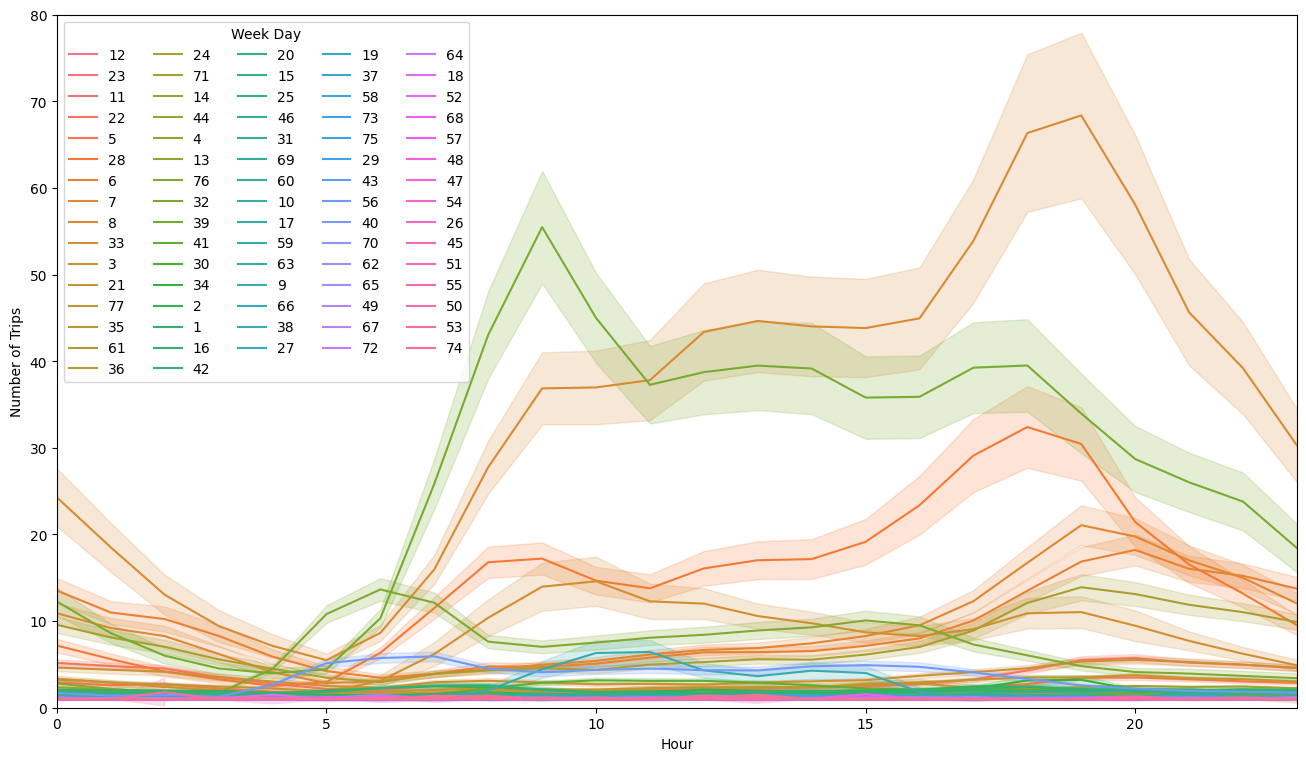

In [32]:
query_ride_counts = """
SELECT
  *
FROM
  `ml-spec.demo1.group_ride_counts_by_all_vars`
WHERE
  year = 2013
"""

df = client.query(query_ride_counts).to_dataframe()
df.rename(columns={'num_trips': 'Number of Trips'}, inplace=True)
df['Week Day'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']]).dt.day_name()

mask = (df['Week Day'] == 'Monday')

fig, ax = plt.subplots(1, figsize=(16, 9))
sns.lineplot(data=df.loc[mask],
             x='Hour', y='Number of Trips',
             hue=df['dropoff_community_area'].astype(str),
             errorbar=('se', 2),  # 2 standard deviations
             ax=ax)
ax.legend(title='Week Day', ncol=5)
ax.set_xlim([0, 23])
ax.set_ylim([0, 80])

We can see that the number of taxi rides varies wignificantly with the areas, with 3 areas peaking beyond 30 taxi rides per hour, and the bulk struggling to reach 5.

The obvious consequence is that the magnitude of statistical noise will significantly vary as a function of the district. A more comprehensive investigation will be conducted in the future, but it is noteworthy to bear this in mind.

We want now to visualize the geographical position of the districs. Therefore, we have obtained their geographical data that we are going to use to compute their centroids on a scatterplot whose hue will represent the amount of taxi rides.

/var/tmp/ipykernel_39736/3832387891.py:17: FutureWarning: The provided callable <function mean at 0x7f762c17dc60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  hue = df.loc[df['Hour'] == hour][[feature, 'Number of Trips']].groupby(feature).agg({'Number of Trips': np.mean})['Number of Trips'].astype(float),


<Axes: xlabel='Lat. Centroid', ylabel='Long. Centroid'>

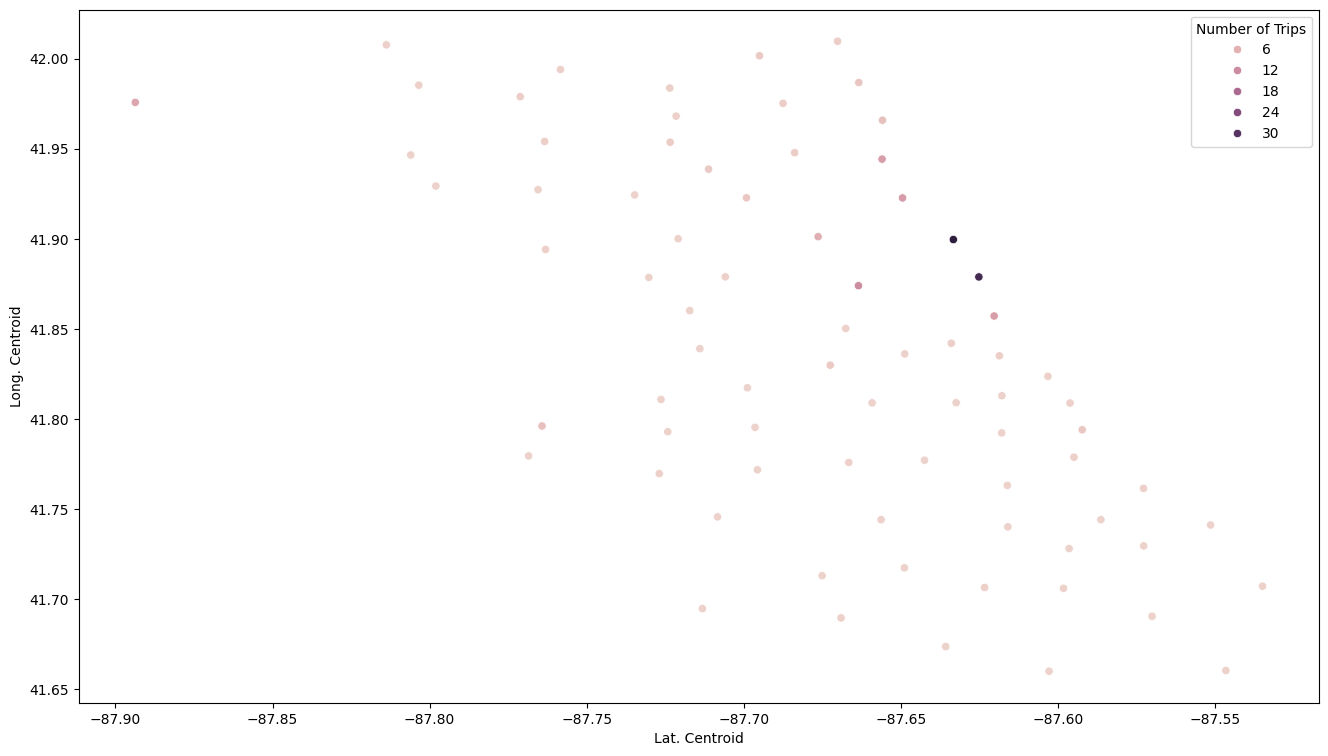

In [33]:
df_areas = pd.read_csv(os.path.join('..', 'data', 'raw', 'CommAreas.csv'), sep=';')
df_areas.columns = df_areas.columns.str.lower()
df_areas['Lat. Centroid'] = df_areas['the_geom'].apply(lambda x: wkt.loads(x).centroid.x)
df_areas['Long. Centroid'] = df_areas['the_geom'].apply(lambda x: wkt.loads(x).centroid.y)
df_areas = df_areas[['area_numbe', 'Lat. Centroid', 'Long. Centroid']]
df_areas = df_areas.rename(columns={'area_numbe': 'Comm. Area'})
df_areas = df_areas.set_index('Comm. Area').sort_index()
df_areas

lat = df_areas['Lat. Centroid'].to_dict()
long = df_areas['Long. Centroid'].to_dict()

feature = 'pickup_community_area'
hour = 16
fig, ax = plt.subplots(1, figsize=(16, 9))
sns.scatterplot(data=df_areas, x='Lat. Centroid', y='Long. Centroid',
                hue = df.loc[df['Hour'] == hour][[feature, 'Number of Trips']].groupby(feature).agg({'Number of Trips': np.mean})['Number of Trips'].astype(float),
                ax=ax)

The data plotted refer to the number of taxi rides at 4 PM. It is obvious to notice that the taxi rides are mostly concentrated in the city center.

Finally, with a forward-looking perspective, we also plot a heatmap connecting the pick-up with the drop-off areas.

<Axes: xlabel='dropoff_community_area', ylabel='pickup_community_area'>

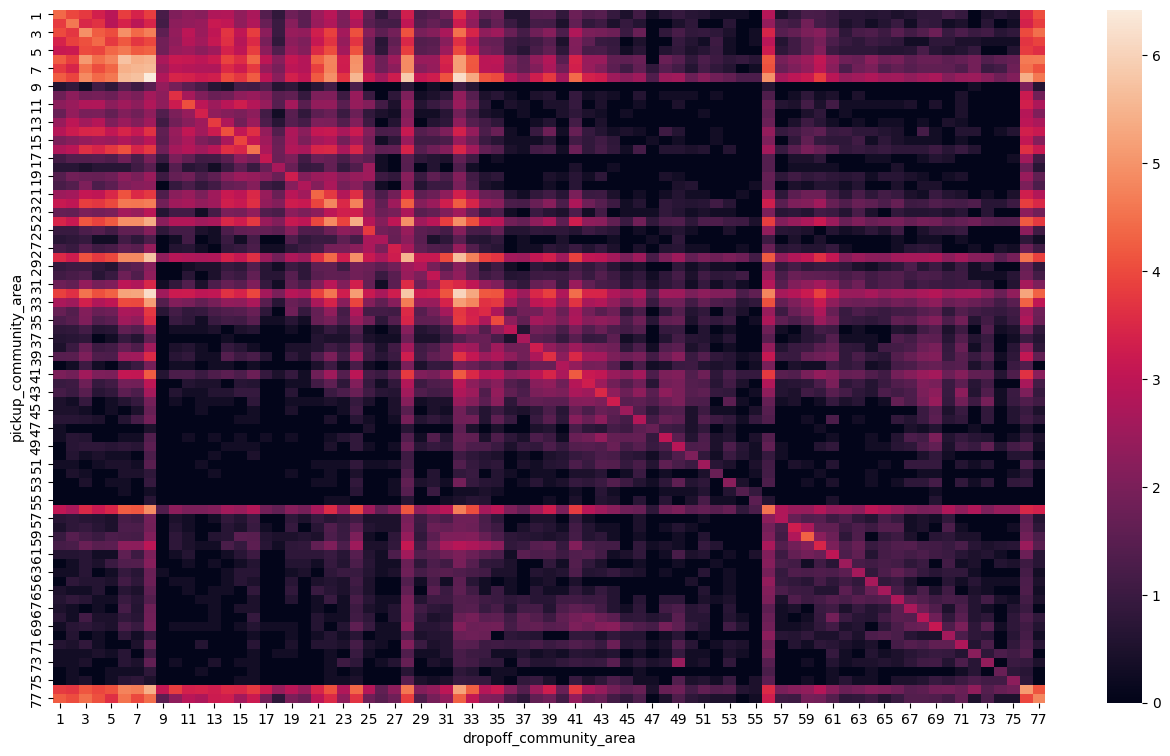

In [34]:
df_hm = df.pivot_table(values='Number of Trips',
                        index='pickup_community_area',
                        columns='dropoff_community_area',
                        aggfunc='sum'
                        )
df_hm = df_hm.fillna(0.).astype(int)
df_hm = np.log10(df_hm + 1)

fig, ax = plt.subplots(1, figsize=(16, 9))
sns.heatmap(data=df_hm, ax=ax)

As expected, the heatmap is highly inhomogeneous. Some areas appear to be very active in terms of pick-ups and drop-offs towards all the other districs (e.g. 9, 56, 76), and others very poor (47, 54, 55). Similarly, some routes between areas are much more common than others.

Most likely, the previously-shown heatmap will vary as a function of the week day and hour, but this analysis is left for the future.